* 데이터의 타입(count data / measured data), sample 개수 등에 따라 적절한 타입의 significance test를 사용함

## 자유도(Degrees of Freedom)
* 표본 데이터에서 계산된 statistic에 적용되는 개념으로, 자유롭게 변경할 수 있는 값의 '개수'를 의미하며, 여러 확률 분포의 모양에 영향을 미침   
예시) 10개의 값이 있는 표본집단의 mean을 알고 있다면, 자유도는 9가 됨

## t-Test
* 단일 표본 평균의 분포를 근사하기 위해 개발된 t-분포에서 이름을 따옴
* 데이터 타입이 numeric(not binary)인 A/B test에서 많이 사용됨

II-iv. Statistical Experiments에서 웹페이지 유형 A/B에 대한 사용자 평균 세션 타임을 permutation test를 통해 귀무가설을 검정했을 때,   
permutation distribution은 아래와 같고 p-value는 0.115 였음

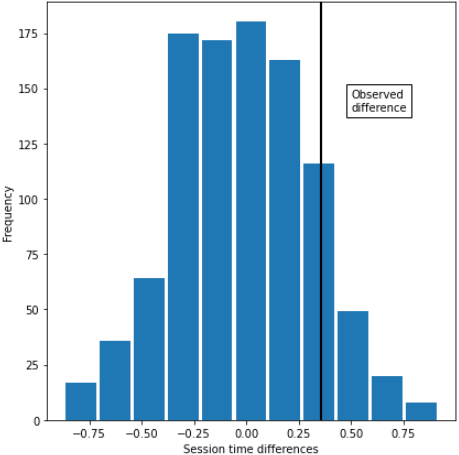

In [ ]:
# web_session 데이터에서 파이썬에서 제공하는 코드를 사용하여 t-statistic 계산하기
# (저번 시간에 permutation test를 통해 statistic과 p-value 계산했었음)
# permutation test를 통해 계산한 p-value와 python 제공 코드로 계산한 p-value를 비교하여 서로 유의했는지 확인

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
session_times = pd.read_csv('web_session_time.csv')
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [4]:
# 귀무가설: Page A, B에 따라 평균 세션 타임이 변하지 않는다 A = B
# 대립가설: Page A 사용 시 Page B보다 평균 세션 타임이 짧다 A < b

t_statistic, p_value = stats.ttest_ind(
    session_times[session_times['Page'] == 'Page A']['Time'],
    session_times[session_times['Page'] == 'Page B']['Time']
)

In [6]:
print(f'p-value for two-tail test', p_value)
print(f'p-value for one-tail test', p_value / 2)

p-value for two-tail test 0.26901024363926024
p-value for one-tail test 0.13450512181963012


## ANOVA
* numeric data를 가진 multiple group 간 통계적으로 유의미한 차이가 있는지 검정하는 절차

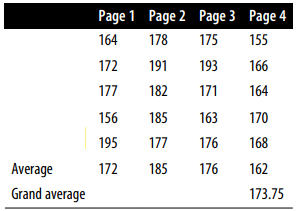
* 4개의 웹페이지에, 각각 5명의 방문자가 잔류했던 시간(second)
* 각 웹페이지에 대한 기록은 서로 완전히 독립적이라고 가정
* 각 웹페이지에 대해 평균 잔류 시간이 유의미하게 차이가 있는지 검정

In [ ]:
# Page에 따른 time의 분포 시각화

In [7]:
four_sessions = pd.read_csv('four_sessions.csv')
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


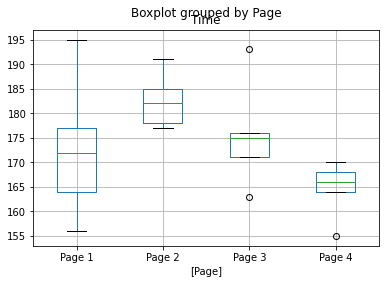

In [8]:
four_sessions.boxplot(by='Page')
plt.show()

* 그룹 간 비교는 6가지 경우가 가능함
* 1 vs 2 / 1 vs 3 / 1 vs 4 / 2 vs 3 / 2 vs 4 / 3 vs 4


* 모든 그룹이 서로 차이가 없다라는 귀무가설은, 실행하는 검사 수가 많을수록 귀무가설의 진위와 상관없이 기각될 확률이 낮아짐
* 위 6가지에 대해 각각 검정을 시행하는 대신, '모든 웹페이지는 차이가 없고, 관찰된 웹페이지 간 차이는 우연히 발생할 수 있는 경우'인가를 검정할 수 있는 실험을 할 수 있음 -> ANOVA


1. 모든 데이터를 섞어 하나의 데이터셋으로 만듬
2. 새로운 데이터셋을 추출하여, 기존 그룹의 개수/데이터셋 크기와 동일한 새로운 그룹 형성
3. 새로운 그룹들의 평균 기록
4. 그룹 평균들의 분산 기록
5. 2~4 단계를 R회 가량 반복
6. resampled variance와 observed variance를 이용하여 p-value 계산

In [ ]:
# permutation test를 통해 variance의 p-value 계산(f)

In [9]:
import random

In [14]:
# 각 그룹(Page 1, 2, 3, 4)의 평균(4개)의 분산
observed_var = four_sessions.groupby('Page').mean().var()['Time']

In [32]:
def perm_anova(df):
    random.shuffle(df['Time'].values)
    return df.groupby('Page').mean().var()['Time']

In [34]:
random.seed(1)

perm_vars = []
for _ in range(1000):
    perm_var = perm_anova(four_sessions.copy())
    perm_vars.append(perm_var)

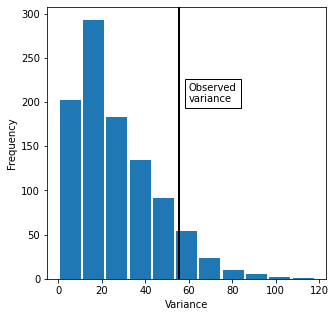

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(perm_vars, bins=11, rwidth=0.9)
ax.axvline(x=observed_var, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_ylabel('Frequency')
ax.set_xlabel('Variance')
plt.show()

In [36]:
import numpy as np

In [37]:
perm_vars = np.array(perm_vars)

In [38]:
print('p-value: ', sum(perm_vars > observed_var) / len(perm_vars))

p-value:  0.087


### F-Statistic
* 두 그룹의 평균을 비교하는 permutation test 대신 t-test를 사용했던 것처럼,   
ANOVA는 F-statistic에 기반함
* F-statistic: residual error로 인한 분산에 대한 그룹 평균 간 분산의 비율을 기반으로 하며,   
이 비율이 높을수록 통계적으로 유의하다고 판단함

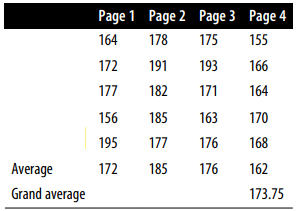
* 4개의 웹페이지에, 각각 5명의 방문자가 잔류했던 시간(second)
* 각 웹페이지에 대한 기록은 서로 완전히 독립적이라고 가정
* 각 웹페이지에 대해 평균 잔류 시간이 유의미하게 차이가 있는지 검정

In [ ]:
# 파이썬 모듈을 사용하여 ANOVA table 형성 및 요소의 의미 확인
# F-statistic: SSR / SSE

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [41]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
# 최소제곱법을 사용해서 회귀모형을 만듬
# '종속변수 ~ 독립변수'

In [42]:
anova_table = sm.stats.anova_lm(model)
anova_table
# df: degree of freedom
# sum_sq = sum of squares
# mean_sq = sum_sq / df : Page-SSR, Residual-SSE
# F = SSR / SSE 

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


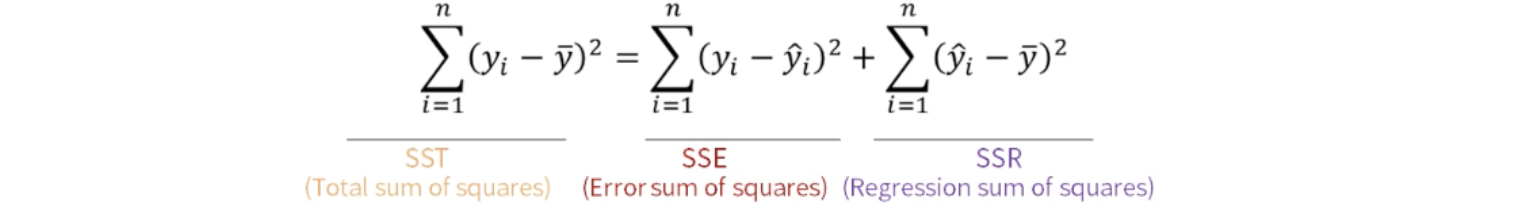

In [45]:
grand_average = 173.75
SST = sum((four_sessions['Time'].ravel() - grand_average)**2)
SSR = sum((four_sessions.groupby('Page').mean().values.ravel() - grand_average)**2) * (four_sessions.shape[0] / 4)
SSE = SST - SSR
print(f'SST: {SST}, SSE: {SSE}, SSR: {SSR}')
print(f'f-statistic: {(SSR/3) / (SSE/16)}')

SST: 2450.25, SSE: 1618.4, SSR: 831.8499999999999
f-statistic: 2.74130828802109


In [ ]:
# 파이썬 모듈을 사용하여 f-statistic과 p-value 계산

In [48]:
res = stats.f_oneway(four_sessions[four_sessions['Page'] == 'Page 1']['Time'],
                  four_sessions[four_sessions['Page'] == 'Page 2']['Time'],
                  four_sessions[four_sessions['Page'] == 'Page 3']['Time'],
                  four_sessions[four_sessions['Page'] == 'Page 4']['Time'])
print('f-statistic: ', res.statistic)
print('p-value: ', res.pvalue)

f-statistic:  2.739825341901467
p-value:  0.0775862152580146


### Two-Way ANOVA
* one-way ANOVA: A/B/C/D test 등, 한가지 요소만 차이나는 경우
* two-way ANOVA: 두가지 요소가 있는 경우   
예시) group A/B,...와 주말/평일


* 'interaction effect'을 식별하여, one-way ANOVA와 유사한 방식으로 처리함   
먼저 grand average의 effect과 treatment effect를 확인한 후, 각 그룹(treatment) 내에서 주말/평일 observation을 분리하여 treatment average와 해당 하위 분류의 average의 차이를 확인

## Chi-Square Test
* count data, 특히 r×c contingency table 형태의 자료를 평가하기 위해 사용
* chi-square statistic: expectation과 observed data가 어느정도 차이나는지 측정
* 두 변수의 독립성(independence) 평가를 위해 사용할 수 있음


* contingency table: 두 변수에 대한 관측값을 요약하고 해석하는 방법   
범주형에 속하는 두 변수에 대한 도수분포를 2차원 표로 작성한 형태
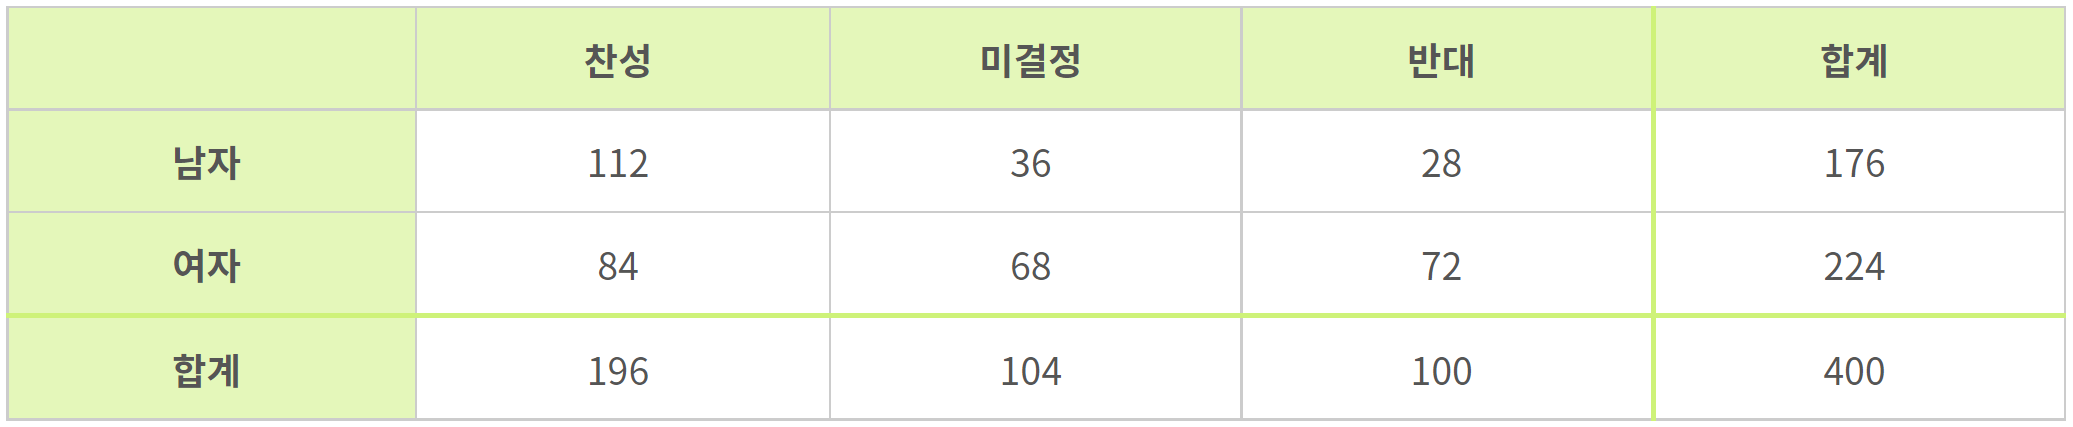

In [ ]:
# df 형태 변환

In [56]:
click_rate = pd.read_csv('click_rates.csv')
click_rate

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986
2,Headline B,Click,8
3,Headline B,No-click,992
4,Headline C,Click,12
5,Headline C,No-click,988


In [57]:
click_rate = click_rate.pivot(index='Click', columns='Headline', values='Rate')

In [58]:
click_rate

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


* null hypothesis: 헤드라인에 따른 클릭 비율의 유의미한 차이는 없다 / 헤드라인에 대한 클릭 비율은 통계적으로 같다   
( (14 + 8 + 12) / 3000 => 0.01133)
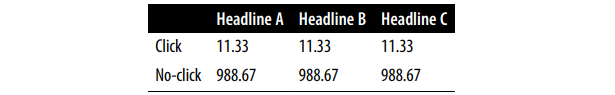


* Pearson residual: expected count와 observed count의 차이 측정
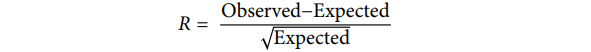

* chi-square statistic: sum of the squared Pearson residuals
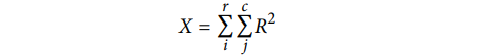

* 자유도: (r-1)*(c-1)

In [ ]:
# 위 계산방법을 사용하여 chi-square statistic 계산

In [62]:
observed_values = click_rate.to_numpy()

In [61]:
expected_values = np.array([[11.33, 11.33, 11.33],
                           [988.67, 988.67, 988.67]])

In [64]:
print(observed_values)
print(expected_values)

[[ 14   8  12]
 [986 992 988]]
[[ 11.33  11.33  11.33]
 [988.67 988.67 988.67]]


In [90]:
chi2 = sum(((observed_values - expected_values)**2 / expected_values).ravel())
print(chi2)

1.666426954553074


In [ ]:
# permutation test를 통해 p-value 계산(chi2)

In [101]:
# resampling algorithm
# 3000 observations: 34 Clicks(1) / 2,966 No-clicks(2)
df_click = [1] * 34 + [0] * 2966

# expected values # click, no-click
expected = [34 / 3, 2966 / 3]

In [ ]:
# headline A, B, C <- 1000, 1000, 1000 (random)
random.shuffle(df_click)
A, B, C = df_click[:1000], df_click[1000:2000], df_click[2000:]

In [79]:
# 새로운 observation과 expected values 차를 계산하는 함수 선언
def chi2_cal(observed, expected):
    # pearson rediduals: (oberved - expected) / root(expected)
    # chi2 = sum(pearson redicuals**2)
    # obseved: [[click_A, click_B, click_C], [no-click_A, no-click_B, no-click_C]]
    # expected: [click, no-click] # 모든 group(A, B, C)에 동일
    
    pearson_residuals2 = [] # (oberved - expected)**2 / expected
    for i, cate in enumerate(observed):
        for obs in cate:
            pearson_residuals2.append((obs - expected[i])**2/expected[i])
            
    return sum(pearson_residuals2)

In [102]:
ch2_observed = chi2_cal(observed_values, expected)
print(ch2_observed)

1.6659394708658917


In [92]:
def perm_test(df, expected):
    # random permutation
    random.shuffle(df)
    A, B, C = df[:1000], df[1000:2000], df[2000:]
    
    obs_clicks = [sum(A), sum(B), sum(C)]
    obs_noClicks = [1000 - sum(A), 1000 - sum(B), 1000 - sum(C)]                                      
    observed = [obs_clicks, obs_noClicks]
    
    return chi2_cal(observed, expected)

In [93]:
random.seed(1)

perm_chi2 = []
for _ in range(1000):
    chi2 = perm_test(df_click, expected)
    perm_chi2.append(chi2)

In [97]:
p_value = sum(perm_chi2 > ch2_observed) / len(perm_chi2)
print('chi2-statistic: ', ch2_observed)
print('p-value: ', p_value)

chi2-statistic:  1.6659394708658917
p-value:  0.446


In [ ]:
# 파이썬 제공 모듈을 사용하여 chi2와 p-value 계산

In [104]:
chisq, pvalue, df, expected = stats.chi2_contingency(observed_values)
print('ch2-statistic: ', chisq)
print('p-value: ', pvalue)

ch2-statistic:  1.6659394708658917
p-value:  0.4347562562343731


In [106]:
expected

array([[ 11.33333333,  11.33333333,  11.33333333],
       [988.66666667, 988.66666667, 988.66666667]])